In [2]:
from tsai.basics import *
import json
import numpy as np
import fastai
import fastai.tabular
from fastai.vision.all import *
from CNN import *
from tsai.data.metadatasets import TSMetaDataset, TSMetaDatasets

In [3]:
with open("data_config.json", "r") as outfile:
    data = json.load(outfile, strict=False)
extent = list(data['extent'])
data_numpy = np.load('data.npy')

d, n_epochs, window_size, batch_size = 128, 35, 60, 16
model = AutoEncoder(d)
load_model(f'model/d_{d}_epoch_{n_epochs}.pkl', model, None)

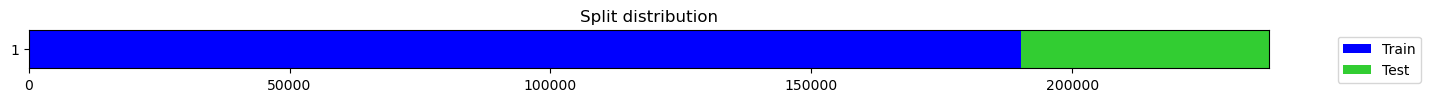

In [4]:
dsets = []
for i in range(data_numpy.shape[0]):
    encoded = model.encrypt(torch.tensor(data_numpy[i], dtype=torch.float32).unsqueeze(0).transpose(0, 1))
    X, y = SlidingWindow(window_size, horizon=1)(encoded.detach().numpy())
    tfms = [None, TSForecasting()]
    dset = TSDatasets(X, y, tfms=tfms)
    dsets.append(dset)
    
metadataset = TSMetaDataset(dsets)
splits = TimeSplitter(show_plot=True)(metadataset)
metadatasets = TSMetaDatasets(metadataset, splits=splits)
dls = TSDataLoaders.from_dsets(metadatasets.train, metadatasets.valid)

In [5]:
model_name = "PatchTST"
learn = ts_learner(dls, arch=model_name)
lr = learn.lr_find().valley

RuntimeError: The size of tensor a (1048576) must match the size of tensor b (8192) at non-singleton dimension 0

In [ ]:
epochs = 100
learn.fit_one_cycle(epochs, lr, cbs=[ShowGraphCallback()])